In [24]:
# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score

from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

# Ignorar los warnings
# -----------------------------------------------------------------------
import warnings
warnings.filterwarnings('ignore')

In [25]:
def metricas(y_train, y_train_pred, y_test, y_test_pred):
    metricas = {
        'train': {
            'r2_score': r2_score(y_train, y_train_pred),
            'MAE': mean_absolute_error(y_train, y_train_pred),
            'MSE': mean_squared_error(y_train, y_train_pred),
            'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred))
        },
        'test': {
            'r2_score': r2_score(y_test, y_test_pred),
            'MAE': mean_absolute_error(y_test, y_test_pred),
            'MSE': mean_squared_error(y_test, y_test_pred),
            'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred))

        }
    }
    return pd.DataFrame(metricas).T

In [26]:
df = pd.read_csv("datos/target_encoding.csv", index_col = 0)

In [27]:
X = df.drop("price", axis = 1)
y = df[["price"]]

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

## Decision Tree

In [29]:
np.set_printoptions(suppress= True)
# Parámetros a evaluar
params_arbol = {
    'max_depth': [14,15,16,17],
    'min_samples_split': [20,25,30,35],
    'min_samples_leaf': [20,30,40,50],
    'max_leaf_nodes': [650, 750, 850, 950]
}

In [30]:
grid_search_arbol = GridSearchCV(DecisionTreeRegressor(),
                                 param_grid= params_arbol,
                                 cv = 5, #cross validation
                                 scoring = "neg_mean_squared_error", #métrica que quiero medir
                                 n_jobs = -1) #use todos los núcleos del ordenador
grid_search_arbol.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [14, 15, 16, 17],
                         'max_leaf_nodes': [650, 750, 850, 950],
                         'min_samples_leaf': [20, 30, 40, 50],
                         'min_samples_split': [20, 25, 30, 35]},
             scoring='neg_mean_squared_error')

In [31]:
modelo_final_arbol = grid_search_arbol.best_estimator_
modelo_final_arbol

DecisionTreeRegressor(max_depth=17, max_leaf_nodes=950, min_samples_leaf=20,
                      min_samples_split=35)

In [32]:
y_pred_test = modelo_final_arbol.predict(X_test)
y_pred_train = modelo_final_arbol.predict(X_train)

In [33]:
df_metricas_arbol = metricas(y_train, y_pred_train, y_test, y_pred_test)
df_metricas_arbol

,r2_score,MAE,MSE,RMSE
train,0.781478,1918.159760,1.002812e+07,3166.720922
test,0.765445,1957.161088,1.072099e+07,3274.292103


In [34]:
#plt.figure(figsize=(20,15))
#plot_tree(decision_tree= modelo_final_arbol,
#          feature_names= X.columns,
#          filled = True)

In [35]:
pd.DataFrame(grid_search_arbol.cv_results_).sort_values(by="rank_test_score", ascending=True).head(2)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
243,0.507347,0.01738,0.008364,0.002106,17,950,20,35,"{'max_depth': 17, 'max_leaf_nodes': 950, 'min_...",-1.122410e+07,-1.136661e+07,-1.092003e+07,-1.138476e+07,-1.108249e+07,-1.119560e+07,175824.612658,1
242,0.503819,0.02715,0.006088,0.000975,17,950,20,30,"{'max_depth': 17, 'max_leaf_nodes': 950, 'min_...",-1.122410e+07,-1.136884e+07,-1.092003e+07,-1.138470e+07,-1.108249e+07,-1.119603e+07,176246.144789,2


In [36]:
df_resultados_arbol = pd.DataFrame(grid_search_arbol.cv_results_)
df_resultados_arbol_filtrado = df_resultados_arbol.filter(like="param").drop(columns = "params")
df_resultados_arbol_filtrado["MSE"] = df_resultados_arbol["mean_test_score"]
df_resultados_arbol_filtrado.head(2)

,param_max_depth,param_max_leaf_nodes,param_min_samples_leaf,param_min_samples_split,MSE
0,14,650,20,20,-1.151358e+07
1,14,650,20,25,-1.151305e+07


In [37]:
df_rmse_prof = np.sqrt(df_resultados_arbol_filtrado.groupby("param_max_depth")["MSE"].mean().abs().reset_index())
df_rmse_prof

,param_max_depth,MSE
0,3.741657,3398.056172
1,3.872983,3392.862920
2,4.000000,3391.764873
3,4.123106,3391.922144


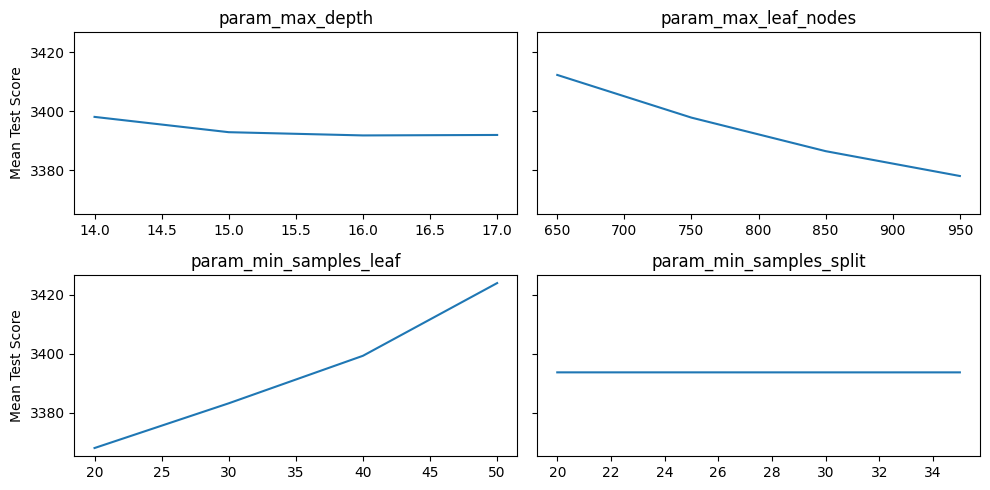

In [38]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5), sharey=True)
axes = axes.flat

for indice, column in enumerate(df_resultados_arbol_filtrado.columns[:-1]):
    df_rmse_prof = (
        np.sqrt(df_resultados_arbol_filtrado.groupby(column)["MSE"].mean().abs())
        .reset_index()
    )
    
    sns.lineplot(
        x=df_rmse_prof[column],
        y=df_rmse_prof["MSE"],
        ax=axes[indice]    
    )
    
    axes[indice].set_title(f"{column}")
    axes[indice].set_xlabel("")
    axes[indice].set_ylabel("Mean Test Score")

plt.tight_layout()
plt.show()

In [39]:
pd.DataFrame(modelo_final_arbol.feature_importances_, columns= ["Importancia"], index=X.columns).sort_values(by="Importancia", ascending = False)

,Importancia
powerCV_robust,0.450543
kilometer_robust,0.319131
fuelType,0.077434
brand,0.058548
yearOfRegistration,0.044704
vehicleType,0.031337
notRepairedDamage,0.012409
gearbox,0.004117
monthOfRegistration,0.001551
abtest,0.000166


## Random Forest

In [40]:
# Definimos un espacio de parámetros para optimizar
params_rf = {
    'n_estimators': [150], # de árboles que queremos en nuestro bosque
    'max_depth': [15, 20, 30],
    'min_samples_split': [15, 20, 25], # mínimo de datos que debe tener la madre
    'min_samples_leaf': [15, 20, 25], # mínimo de datos que debe tener el hijo
    'max_leaf_nodes': [100, 200, 300] # de nodos finales
}

modelo_rf = RandomForestRegressor(random_state=42, bootstrap=True) 
#bootstrap es muestreo con reemplazo, permite que el mismo dato esté en distintos árboles

grid_search_rf = GridSearchCV(modelo_rf,
                              params_rf,
                              cv = 5,
                              scoring = "neg_mean_squared_error",
                              n_jobs = -1)

grid_search_rf.fit(X_train, y_train["price"].values) #debemos pasar array de una dimensión
modelo_final_rf = grid_search_rf.best_params_

In [41]:
modelo_final_rf_dict = grid_search_rf.best_params_
modelo_final_rf_dict

{'max_depth': 20,
 'max_leaf_nodes': 300,
 'min_samples_leaf': 15,
 'min_samples_split': 15,
 'n_estimators': 150}

In [42]:
modelo_final_rf = grid_search_rf.best_estimator_
modelo_final_rf

RandomForestRegressor(max_depth=20, max_leaf_nodes=300, min_samples_leaf=15,
                      min_samples_split=15, n_estimators=150, random_state=42)

In [43]:
y_pred_test_rf = modelo_final_rf.predict(X_test)
y_pred_train_rf = modelo_final_rf.predict(X_train)

In [44]:
df_metricas_rf = metricas(y_train, y_pred_train_rf, y_test, y_pred_test_rf)
df_metricas_rf

,r2_score,MAE,MSE,RMSE
train,0.759901,2051.522960,1.101828e+07,3319.379598
test,0.756270,2052.500985,1.114035e+07,3337.715663


In [45]:
df_importancia_rf = pd.DataFrame(modelo_final_rf.feature_importances_, columns= ["Importancia"], index=X.columns).sort_values(by="Importancia", ascending = False)
df_importancia_rf

,Importancia
powerCV_robust,0.456287
kilometer_robust,0.328245
fuelType,0.077610
brand,0.051461
yearOfRegistration,0.045650
vehicleType,0.025111
notRepairedDamage,0.011604
gearbox,0.003461
monthOfRegistration,0.000525
abtest,0.000026


## Gradient Boost

In [46]:
params_gb = {
    'n_estimators': [150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [100, 200, 300] 
}

modelo_gb = GradientBoostingRegressor(random_state=42)

grid_search_gb = GridSearchCV(modelo_gb,
                              params_gb,
                              cv = 5,
                              scoring = "neg_mean_squared_error",
                              n_jobs = -1)

grid_search_gb.fit(X_train, y_train["price"].values) #debemos pasar array de una dimensión

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [15, 20, 25],
                         'min_samples_leaf': [100, 200, 300],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [150]},
             scoring='neg_mean_squared_error')

In [ ]:
from joblib import dump

# Save the GridSearchCV object
dump(grid_search_gb, 'datos/grid_search_gb.joblib')

['datos/grid_search_gb.joblib']

In [77]:
from joblib import load

# Load the GridSearchCV object
grid_search_gb = load('datos/grid_search_gb.joblib')

In [47]:
modelo_final_gb = grid_search_gb.best_estimator_
modelo_final_gb

GradientBoostingRegressor(learning_rate=0.2, max_depth=25, min_samples_leaf=100,
                          n_estimators=150, random_state=42)

In [48]:
y_pred_test_gb = modelo_final_gb.predict(X_test)
y_pred_train_gb = modelo_final_gb.predict(X_train)

In [49]:
df_metricas_gb = metricas(y_train, y_pred_train_gb, y_test, y_pred_test_gb)
df_metricas_gb

,r2_score,MAE,MSE,RMSE
train,0.860503,1515.672598,6.401615e+06,2530.141382
test,0.819571,1676.528231,8.247026e+06,2871.763542


Con sample

In [55]:
X_sample = X_train.sample(30000, random_state=42)
y_sample = y_train.sample(30000, random_state=42)

In [56]:
params_gb = {
    'n_estimators': [150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [100, 200, 300] 
}

modelo_gb = GradientBoostingRegressor(random_state=42)

grid_search_gb = GridSearchCV(modelo_gb,
                              params_gb,
                              cv = 5,
                              scoring = "neg_mean_squared_error",
                              n_jobs = -1)

grid_search_gb.fit(X_sample, y_sample["price"].values) #debemos pasar array de una dimensión

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [15, 20, 25],
                         'min_samples_leaf': [100, 200, 300],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [150]},
             scoring='neg_mean_squared_error')

In [62]:
y_pred_test_gb = modelo_final_gb.predict(X_test)
y_pred_train_gb = modelo_final_gb.predict(X_sample)

In [72]:
y_pred_test_gb.shape

(99185,)

In [73]:
df_metricas_gb = metricas(y_train.sample(30000, random_state=42), y_pred_train_gb, y_test.sample(99185, random_state=42), y_pred_test_gb)
df_metricas_gb

,r2_score,MAE,MSE,RMSE
train,0.860025,1520.769379,6.424947e+06,2534.747904
test,-0.836109,6130.801724,8.392456e+07,9161.034677


## XGBoost Regressor

In [ ]:
params_xgb = {
    'max_depth': [15, 20, 25],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [150],
    'min_child_weight': [1, 2, 4],
    'colsample_bytree': [0.8, 1.0]   
}

modelo_xgb = XGBRegressor(random_state=42)

grid_search_xgb = GridSearchCV(modelo_xgb,
                              params_xgb,
                              cv = 5,
                              scoring = "neg_mean_squared_error",
                              n_jobs = -1)

grid_search_xgb.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [15, 20, 25],
                         'min_child_weight': [1, 2, 4], 'n_estimators': [150]},
             scoring='neg_mean_squared_error')

In [51]:
modelo_final_xgb = grid_search_xgb.best_estimator_
modelo_final_xgb

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [52]:
y_pred_test_xgb = modelo_final_xgb.predict(X_test)
y_pred_train_xgb = modelo_final_xgb.predict(X_train)

In [53]:
df_metricas_xgb = metricas(y_train, y_pred_train_xgb, y_test, y_pred_test_xgb)
df_metricas_xgb

,r2_score,MAE,MSE,RMSE
train,0.934899,1062.415011,2.987532e+06,1728.447963
test,0.819941,1642.941162,8.230125e+06,2868.819383
